# Binary Classification - 4 ways

Binary classification performed using:
* Multilayer Perceptron
* Logistic Regression
* Linear Discriminant Analysis (LDA)
* Quadratic Discriminant Analysis (QDA)

The following implementation works for any number of samples.




## Import dependencies

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt

## Set random seed

In [66]:
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

## Arguments regarding data, model and training

In [67]:
N = 4096
epochs = 10
iters = 100
learning_rate = 0.001
d = 2

## Generate the Data

In [68]:
def sample_binary_data(sz):
  p_1 = np.random.multivariate_normal(mu_1, cov_1, size=sz)
  p_2 = np.random.multivariate_normal(mu_2, cov_2, size=sz)
  X = torch.cat([torch.Tensor(p_1), torch.Tensor(p_2)], dim=0)
  y = torch.zeros(sz*2)
  y[N//2:] = 1.
  return torch.Tensor(X), torch.Tensor(y)

mu_1 = torch.Tensor(
    [7, 7]
)
mu_2 = torch.Tensor(
    [0, 0]
)

cov_1 = torch.Tensor(
    [[9., 2.0],
    [2.0, 9.]]
)

cov_2 = torch.Tensor(
    [[11., -3.5],
    [-3.5, 11.]]
)

# Training data
X_train, y_train = sample_binary_data(N // 2)

# Validation data
X_val, y_val = sample_binary_data(N // 2)

## Visualize Data

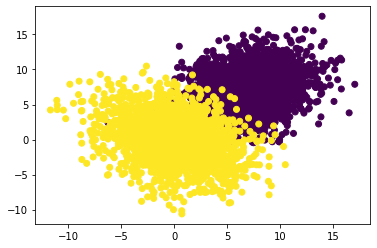

In [69]:
X_np = X_train.numpy()
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_train.numpy())

# Binary classification using MLP

In [70]:
class MLP(nn.Module):
  """
   A neural network with a single hidden layer
   Structure is as follows:
   nn.Sequential(
        nn.Linear(input_size, hidden_size) + nn.ReLU(), # Fully connected layer with ReLU activation
        nn.Linear(hidden_size, output_size) # Final fully connected layer
    )
  """
  def __init__(self, input_size, hidden_size, output_size):
    """
    Initializing the parameters of MLP

    Args:
      input_size: Int
        Number of input features
      hidden_size: Int
        Number of units in the hidden layer
      output_size: Int
        Number of output features

    Returns:
      Nothing
    """
    super(MLP, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size)
    )

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.Tensor
        2D tensor of features

    Returns:
      Torch tensor of model predictions
    """

    return self.layers(x)

In [71]:
# Creating an instance
mlp = MLP(input_size = 2, hidden_size = 64, output_size = 1)
# Instantiate adam optimizer
adam_optimizer = torch.optim.Adam(mlp.parameters(), lr= learning_rate)
# Create a binary cross entropy with logits loss function
criterion = nn.BCEWithLogitsLoss()

In [72]:
def train(X, y, model, criterion, optimizer, iters, acc_logits):
  """
  Training function

  Args:
    X: torch.Tensor
      Features (input) with shape torch.Size([N, d])
    y: torch.Tensor
      Labels (targets) with shape torch.Size([N, 1])
    model: torch nn.Module
      The neural network
    criterion: function
      Loss function
    optimizer: function
      Optimizer
    iters: int
      Number of training iterations
    acc_logits: bool
      Flag for accuracy calculation

  Returns:
    avg_loss: float
      Average loss over all iters
    acc: float
      Training accuracy
  """
  model.train()
  
  loss_record = [] # Keeping records of loss
  correct = 0
  total = 0
  
  for i in range(iters):
    # Reset all gradients to zero
    optimizer.zero_grad()
    
    # Forward pass (Compute the output of the model on the features (inputs))
    y_pred = model(X)
    
    # Compute the loss
    loss = criterion(torch.squeeze(y_pred), y)
    
    # Perform backpropagation and compute the gradients
    loss.backward()

    # Optimizer takes a tiny step in the steepest direction (negative of gradient) and "updates" the weights and biases of the network
    optimizer.step()

    loss_record.append(loss.item())
    
    # Ground truth labels
    total += y.size(0)

    if acc_logits:
      # Number of correct predictions of the MLP model
      correct += torch.eq(y_pred.squeeze() >= 0., y).sum() 
    else:
      # Number of correct predictions of the logistic regression model
      correct += torch.eq(y_pred.squeeze() >= 0.5, y).sum()
  
  # Compute average loss over all iterations
  avg_loss = np.sum(loss_record) / iters
  # Compute accuracy using correct and total
  acc = 100 * correct / total

  return avg_loss, acc

def eval(X, y, model, criterion, acc_logits):
  """
  Function to gauge network performance

  Args:
    X: torch.tensor
      Features (input) with shape torch.Size([N, d])
    y: torch.tensor
      Labels (targets) with shape torch.Size([N, 1])
    model: torch nn.Module
      The neural network
    criterion: function
      Loss function
    acc_logits: bool
      Flag for accuracy calculation

  Returns:
    eval_loss: float 
      Scalar loss value over (X, y) using the model 
    eval_acc: float
      Validation accuracy 
  """

  model.eval()

  correct = 0
 
  y_pred = model(X)
  
  eval_loss = criterion(torch.squeeze(y_pred), y).item()
  
  if acc_logits:
    # Number of correct predictions using the MLP model
    correct += torch.eq(y_pred.squeeze() >= 0., y).sum()
  else:
    # Number of correct predictions using the logistic regression model
    correct += torch.eq(y_pred.squeeze() >= 0.5, y).sum()
  
  # Compute accuracy
  eval_acc = 100 * correct / y.shape[0]

  return eval_loss, eval_acc

In [73]:
def main(model, optimizer, criterion, epochs, iters, X_train, X_val, y_train, y_val, acc_logits=True):
  """
  Train the model and tests the learned model
    
    Args:
      model: torch nn.Module
        The neural network
      optimizer: function
        optimizer
      criterion: function
        Loss function
      epochs: int
        number of training and validation iterations
      iters: int
        Number of training iterations
      X_train: torch.Tensor
        Training features (input) with shape torch.Size([N, d])
      X_val: torch.Tensor
        Validation features (input) with shape torch.Size([N, d])
      y_train: torch.tensor
        Training labels (targets) with shape torch.Size([N, 1])
      y_val: torch.tensor
        Validation labels (targets) with shape torch.Size([N, 1])
      acc_logits: bool
        Flag for accuracy calculation

    Returns:
      Nothing
  """
  for i in range(epochs):
    losses, train_acc = train(X_train, y_train, model, criterion, optimizer, iters, acc_logits)
    val_loss, val_acc = eval(X_val, y_val, model, criterion, acc_logits)
    print(f'Epoch: {i} train loss: {losses:.2f} Validation loss: {val_loss:.2f} train accuracy: {train_acc:.2f} validation accuracy: {val_acc:.2f}')

main(mlp, adam_optimizer, criterion, epochs, iters, X_train, X_val, y_train, y_val)

Epoch: 0 train loss: 0.28 Validation loss: 0.20 train accuracy: 87.15 validation accuracy: 92.24
Epoch: 1 train loss: 0.16 Validation loss: 0.17 train accuracy: 93.74 validation accuracy: 93.63
Epoch: 2 train loss: 0.14 Validation loss: 0.15 train accuracy: 94.87 validation accuracy: 94.53
Epoch: 3 train loss: 0.12 Validation loss: 0.14 train accuracy: 95.46 validation accuracy: 94.90
Epoch: 4 train loss: 0.12 Validation loss: 0.14 train accuracy: 95.82 validation accuracy: 94.95
Epoch: 5 train loss: 0.11 Validation loss: 0.13 train accuracy: 95.85 validation accuracy: 94.87
Epoch: 6 train loss: 0.11 Validation loss: 0.13 train accuracy: 95.99 validation accuracy: 94.87
Epoch: 7 train loss: 0.11 Validation loss: 0.13 train accuracy: 96.01 validation accuracy: 94.87
Epoch: 8 train loss: 0.11 Validation loss: 0.13 train accuracy: 96.04 validation accuracy: 94.92
Epoch: 9 train loss: 0.11 Validation loss: 0.13 train accuracy: 96.01 validation accuracy: 94.92


## Plotting function

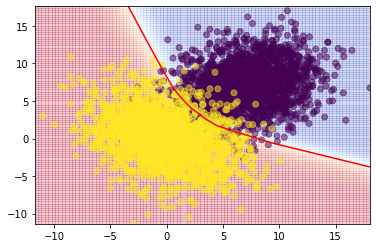

In [74]:
points = 100

min_x = min(X_train[:,0].min(), X_val[:,0].min())
max_x = max(X_train[:,0].max(), X_val[:,0].max())
min_y = min(X_train[:,1].min(), X_val[:,1].min())
max_y = max(X_train[:,1].max(), X_val[:,1].max())

xx = np.linspace(min_x, max_x, points)
yy = np.linspace(min_y, max_y, points)
with torch.no_grad():
  mesh = torch.Tensor(np.meshgrid(xx, yy))
  xx = mesh[0].numpy()
  yy = mesh[1].numpy()
  mesh = mesh.permute(1, 2, 0).reshape(-1, 2)
  out = torch.sigmoid(mlp(mesh)).view(points, points).numpy()

plt.clf()
plt.contour(xx, yy, out, levels=[0.5], colors=['red'])
plt.pcolormesh(xx, yy, out, alpha=0.2, cmap='coolwarm')
plt.scatter(X_val[:,0], X_val[:,1], c=y_val, alpha=0.5)
plt.show()

# Binary Classification using Logistic Regression

In [75]:
class LogisticReg(nn.Module):
 
  # A single layer neural network
 
  def __init__(self, input_size, output_size):

    """
    Initializing the parameters of the network

    Args:
      input_size: Int
        Number of input features
      output_size: Int
        Number of output features

    Returns:
      Nothing
    """
    super(LogisticReg, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(input_size, output_size)
    )

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.Tensor
        2D tensor of features

    Returns:
      Torch tensor of model predictions
    """

    return torch.sigmoid(self.layers(x))

In [76]:
# Creating an instance
net = LogisticReg(input_size = 2, output_size = 1)
# Create a binary cross entropy loss function
criterion = nn.BCELoss()
# Instantiate adam optimizer
adam_optimizer = torch.optim.Adam(net.parameters(), lr= learning_rate)

In [77]:
# Main loop
main(net, adam_optimizer, criterion, 50, iters, X_train, X_val, y_train, y_val, False)
y_pred = net(X_train).detach().numpy()
y_pred = net(X_val).detach().numpy()

Epoch: 0 train loss: 0.82 Validation loss: 0.75 train accuracy: 61.43 validation accuracy: 65.33
Epoch: 1 train loss: 0.69 Validation loss: 0.66 train accuracy: 68.65 validation accuracy: 69.04
Epoch: 2 train loss: 0.60 Validation loss: 0.58 train accuracy: 71.32 validation accuracy: 71.14
Epoch: 3 train loss: 0.53 Validation loss: 0.51 train accuracy: 73.32 validation accuracy: 73.12
Epoch: 4 train loss: 0.47 Validation loss: 0.46 train accuracy: 75.12 validation accuracy: 75.49
Epoch: 5 train loss: 0.43 Validation loss: 0.42 train accuracy: 77.76 validation accuracy: 78.20
Epoch: 6 train loss: 0.39 Validation loss: 0.39 train accuracy: 79.93 validation accuracy: 80.96
Epoch: 7 train loss: 0.37 Validation loss: 0.37 train accuracy: 82.21 validation accuracy: 82.89
Epoch: 8 train loss: 0.34 Validation loss: 0.35 train accuracy: 84.28 validation accuracy: 84.50
Epoch: 9 train loss: 0.33 Validation loss: 0.33 train accuracy: 85.80 validation accuracy: 85.52
Epoch: 10 train loss: 0.31 Val

## Plotting function

In [78]:
weight = net.layers[0].weight.detach().numpy()
bias = net.layers[0].bias.detach().numpy()
x1 = torch.tensor([torch.min(X_train), torch.max(X_train)])
x_1 = torch.tensor([torch.min(X_val), torch.max(X_val)])
x2 = (-weight[0][0] * x1 - bias) / weight[0][1]
x_2 = (-weight[0][0] * x_1 - bias) / weight[0][1]

In [79]:
def plot(X, y, x1, x2):
  plt.figure(figsize=(8, 5))
  plt.xlabel('x (inputs)')
  plt.ylabel('y (labels)')
  plt.title("Binary Classification")
  X_np = X.numpy()
  plt.scatter(X_np[:, 0], X_np[:, 1], c=y.numpy())
  plt.plot(x1, x2, label="Prediction")
  plt.legend()
  plt.show()

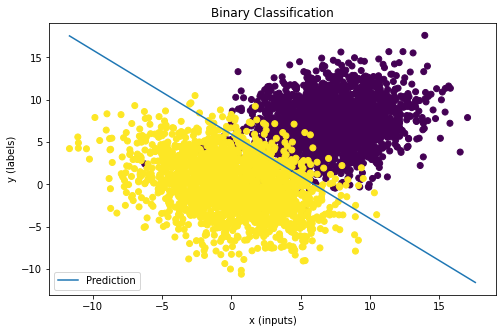

In [80]:
# Performance of training data
plot(X_train, y_train, x1, x2)

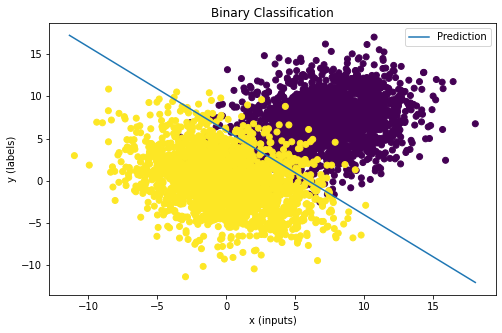

In [81]:
# Performance of validation data
plot(X_val, y_val, x_1, x_2)

# Linear or "Fisher" Discriminant Analysis (LDA)

In [82]:
def accuracy(pred, y):
  """
  Function to calculate the accuracy of model predictions

  Args:
    pred: Torch tensor
      model predictions with shape torch.size([N,1])
    y: Torch tensor
      labels with shape torch.size([N,1])
  
  Returns:
    a: float
      accuracy of model predictions
  """
  a = torch.eq(pred, y.long()).double().mean() * 100
  
  return a

In [83]:
class LDA():
 
  def __init__(self, X, y):
    """
    Separate the training data according to its respective classes

    Args:
      X: torch.Tensor
        Features (input) with shape torch.Size([N, d])
      y: torch.Tensor
        Labels (targets) with shape torch.Size([N, 1])

    Returns:
      Nothing
    """
    idx_zero = torch.where(y == 0)[0]
    idx_one = torch.where(y == 1)[0]
    self.X0 = X[idx_zero]
    self.X1 = X[idx_one]

  def pi(self, N, y):
    """
    Calculate the class prior 

    Args:
      N: int
        Number of training samples
      y: torch.Tensor
        Labels (targets) with shape torch.Size([N, 1])

    Returns:
      Nothing
    """
    self.pi1 = torch.sum(y) / N
    self.pi0 = torch.sum(1 - y) / N
    
  def means(self):

    # Calculate the class-specific means
    
    self.mean0 = torch.mean(self.X0, axis = 0).unsqueeze(0)
    self.mean1 = torch.mean(self.X1, axis = 0).unsqueeze(0)

  def covariance(self):

    # Calculate the shared covariance matrix
    
    cov0 = torch.cov(self.X0.T, correction=0) * self.pi0
    cov1 = torch.cov(self.X1.T, correction=0) * self.pi1
    self.cov = cov0 + cov1
    
  def predict(self, X):
    """
    Predict the "most likely" class for each sample in X

    Args:
      X: torch.Tensor
        Features (input) with shape torch.Size([N, d])

    Returns:
      pred: torch.tensor
        model predictions with shape torch.size([N,1])
    """
    pred0 = torch.zeros(X.shape[0])
    pred1 = torch.zeros(X.shape[0])
    
    inv_cov = torch.linalg.inv(self.cov)
    self.diff0 = X.sub(self.mean0)
    self.diff1 = X.sub(self.mean1)

    for i in range(X.shape[0]):
      pred0[i] = self.pi0 * torch.exp(-0.5 * self.diff0[i] @ inv_cov @ self.diff0[i].T)
      pred1[i] = self.pi1 * torch.exp(-0.5 * self.diff1[i] @ inv_cov @ self.diff1[i].T)
    
    preds = pred1 + pred0
    
    class0 = pred0/preds
    class1 = pred1/preds

    pred = (class1 >= class0).long()

    return pred


In [84]:
# Create an instance of the class
lda = LDA(X_train, y_train)
lda.pi(N, y_train)
lda.means()
lda.covariance()

# Performance on training data
pred = lda.predict(X_train)
print(f'Train Accuracy: {accuracy(pred, y_train):.2f}')

# Performance on validation data
pred = lda.predict(X_val)
print(f'Validation Accuracy: {accuracy(pred, y_val):.2f}')

Train Accuracy: 95.43
Validation Accuracy: 94.68


# Quadratic Discriminant Analysis (QDA)

In [88]:
class QDA():
 
  def __init__(self, X, y):

    """
    Separate the training data according to its respective classes

    Args:
      X: torch.Tensor
        Features (input) with shape torch.Size([N, d])
      y: torch.Tensor
        Labels (targets) with shape torch.Size([N, 1])

    Returns:
      Nothing
    """

    idx_zero = torch.where(y == 0)[0]
    idx_one = torch.where(y == 1)[0]
    self.X0 = X[idx_zero]
    self.X1 = X[idx_one]

  def pi(self, N, y):
    """
    Calculate the class prior 

    Args:
      N: int
        Number of training samples
      y: torch.Tensor
        Labels (targets) with shape torch.Size([N, 1])

    Returns:
      Nothing
    """ 
    
    self.pi1 = torch.sum(y) / N
    self.pi0 = torch.sum(1 - y) / N
    
  def means(self):

    # Calculate the class-specific means
    
    self.mean0 = torch.mean(self.X0, axis = 0).unsqueeze(0)
    self.mean1 = torch.mean(self.X1, axis = 0).unsqueeze(0)

  def covariance(self):

    # Calculate the class-specific covariance matrices
    
    self.cov0 = torch.cov(self.X0.T, correction=0)
    self.cov1 = torch.cov(self.X1.T, correction=0)
    
  def predict(self, X):
    """
    Predict the "most likely" class for each sample in X

    Args:
      X: torch.Tensor
        Features (input) with shape torch.Size([N, d])

    Returns:
      pred: torch.tensor
        model predictions with shape torch.size([N,1])
    """

    pred0 = torch.zeros(X.shape[0])
    pred1 = torch.zeros(X.shape[0])
    
    inv_cov0 = torch.linalg.inv(self.cov0)
    inv_cov1 = torch.linalg.inv(self.cov1)
    cov0_det = torch.linalg.det(self.cov0)
    cov1_det = torch.linalg.det(self.cov1)
    self.diff0 = X.sub(self.mean0)
    self.diff1 = X.sub(self.mean1)

    for i in range(X.shape[0]):
      pred0[i] = self.pi0 * (cov0_det**-0.5) * torch.exp(-0.5 * self.diff0[i] @ inv_cov0 @ self.diff0[i].T)
      pred1[i] = self.pi1 * (cov1_det**-0.5) * torch.exp(-0.5 * self.diff1[i] @ inv_cov1 @ self.diff1[i].T)
    
    preds = pred1 + pred0
    
    class0 = pred0/preds
    class1 = pred1/preds

    pred = (class1 >= class0).long()

    return pred


In [89]:
# Create an instance of the class
qda = QDA(X_train, y_train)
qda.pi(N, y_train)
qda.means()
qda.covariance()

# Performance on training data
pred = qda.predict(X_train)
print(f'Train Accuracy: {accuracy(pred, y_train):.2f}')

# Performance on validation data
pred = qda.predict(X_val)
print(f'Validation Accuracy: {accuracy(pred, y_val):.2f}')

Train Accuracy: 95.87
Validation Accuracy: 94.95


## QDA using Scikit-learn

In [90]:
def acc(pred, y):
  # Calculate the accuracy of the model predictions
   a = np.equal(pred, y).mean() * 100
   return a

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

X_train_np, y_train_np = X_train.numpy(), y_train.numpy()
X_val_np, y_val_np = X_val.numpy(), y_val.numpy()

clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train_np, y_train_np)

# Performance on training data
y_pred = clf.predict(X_train_np)
print(f'Train Accuracy: {acc(y_pred, y_train_np):.2f}')

# Performance on validation data
y_pred = clf.predict(X_val)
print(f'Validation Accuracy: {acc(y_pred, y_val_np):.2f}')

Train Accuracy: 95.87
Validation Accuracy: 94.95
